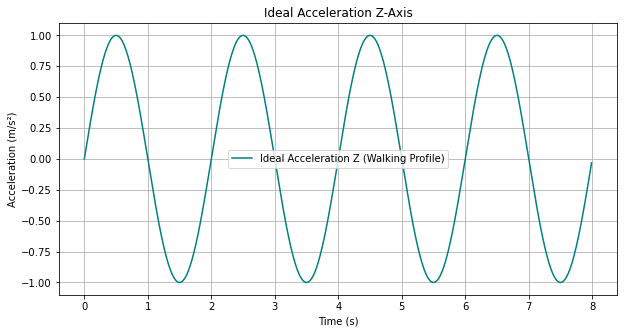

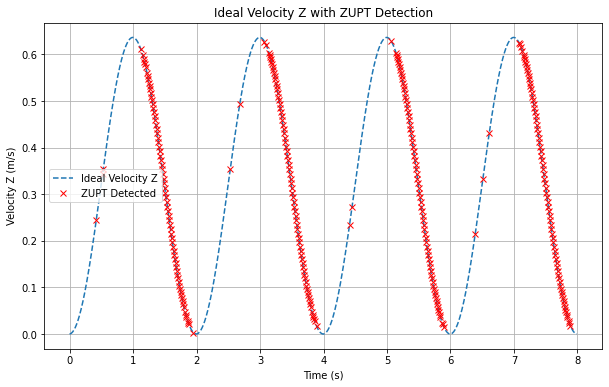

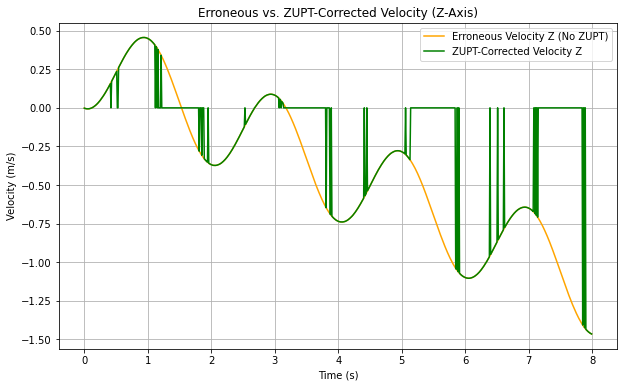

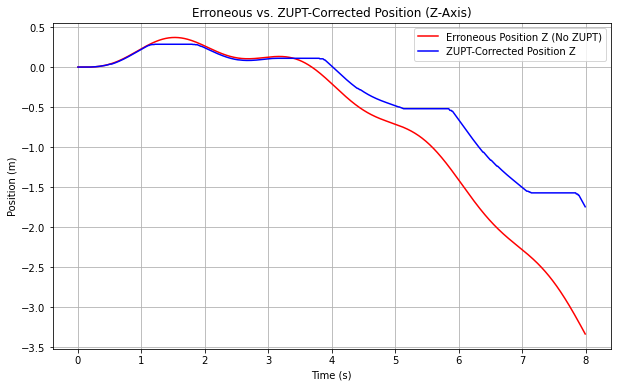

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def apply_imu_errors(acc_x, acc_y, acc_z, ssft, non_lin, nsd, cross_axis_sensitivity, noise_bandwidth):
    nsd_mps2 = nsd * 0.0098
    noise_std = nsd_mps2 * np.sqrt(noise_bandwidth)
    
    error_x = acc_x * (1 + ssft) + non_lin * (acc_x ** 2)
    error_y = acc_y * (1 + ssft) + non_lin * (acc_y ** 2)
    error_z = acc_z * (1 + ssft) + non_lin * (acc_z ** 2)

    corrected_x = error_x + cross_axis_sensitivity * (error_y + error_z)
    corrected_y = error_y + cross_axis_sensitivity * (error_x + error_z)
    corrected_z = error_z + cross_axis_sensitivity * (error_x + error_y)

    corrected_x += np.random.normal(0, noise_std, size=acc_x.shape)
    corrected_y += np.random.normal(0, noise_std, size=acc_y.shape)
    corrected_z += np.random.normal(0, noise_std, size=acc_z.shape)

    return corrected_x, corrected_y, corrected_z

# --- Simulation Parameters ---
duration = 8
dt = 0.01
t = np.arange(0, duration, dt)

# --- Ideal Acceleration Signals ---
acc_x = np.zeros_like(t)
acc_y = -9.8 * np.ones_like(t)
acc_z = 1.0 * np.sin(2 * np.pi * 0.5 * t)

# --- Error Parameters ---
ssft = -0.005
non_lin = 0.005
nsd = 0.23  # mg/√Hz
cross_axis_sensitivity = 0.02
noise_bandwidth = 20

# --- Apply IMU Errors ---
acc_x_err, acc_y_err, acc_z_err = apply_imu_errors(
    acc_x, acc_y, acc_z, ssft, non_lin, nsd, cross_axis_sensitivity, noise_bandwidth
)

# --- Velocity Integration ---
v_x = np.cumsum(acc_x_err) * dt
v_y = np.cumsum(acc_y_err) * dt
v_z = np.cumsum(acc_z_err) * dt

# --- ZUPT Detection ---
acc_mag = np.sqrt(acc_x_err**2 + acc_y_err**2 + acc_z_err**2)
zupt_thresh = 0.5  # m/s²
zupt_mask = np.abs(acc_mag - 9.8) < zupt_thresh

# --- ZUPT-Corrected Velocity ---
v_x_zupt = v_x.copy()
v_y_zupt = v_y.copy()
v_z_zupt = v_z.copy()
v_x_zupt[zupt_mask] = 0
v_y_zupt[zupt_mask] = 0
v_z_zupt[zupt_mask] = 0

# --- Position Integration ---
p_x = np.cumsum(v_x) * dt
p_y = np.cumsum(v_y) * dt
p_z = np.cumsum(v_z) * dt
p_x_zupt = np.cumsum(v_x_zupt) * dt
p_y_zupt = np.cumsum(v_y_zupt) * dt
p_z_zupt = np.cumsum(v_z_zupt) * dt

# --- Ideal Integration ---
v_x_ideal = np.cumsum(acc_x) * dt
v_y_ideal = np.cumsum(acc_y) * dt
v_z_ideal = np.cumsum(acc_z) * dt
p_x_ideal = np.cumsum(v_x_ideal) * dt
p_y_ideal = np.cumsum(v_y_ideal) * dt
p_z_ideal = np.cumsum(v_z_ideal) * dt

# --- Plot Ideal Acceleration (Z-axis) ---
plt.figure(figsize=(10, 5))
plt.plot(t, acc_z, label='Ideal Acceleration Z (Walking Profile)', color='teal')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Ideal Acceleration Z-Axis')
plt.grid(True)
plt.legend()
plt.show()

# --- Plot Ideal Velocity Z + ZUPT Markers ---
plt.figure(figsize=(10, 6))
plt.plot(t, v_z_ideal, label='Ideal Velocity Z', linestyle='--')
plt.plot(t[zupt_mask], v_z_ideal[zupt_mask], 'rx', label='ZUPT Detected')
plt.xlabel('Time (s)')
plt.ylabel('Velocity Z (m/s)')
plt.title('Ideal Velocity Z with ZUPT Detection')
plt.legend()
plt.grid(True)
plt.show()

# --- Comparison Plot: Velocity with vs without ZUPT ---
plt.figure(figsize=(10, 6))
plt.plot(t, v_z, label='Erroneous Velocity Z (No ZUPT)', color='orange')
plt.plot(t, v_z_zupt, label='ZUPT-Corrected Velocity Z', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Erroneous vs. ZUPT-Corrected Velocity (Z-Axis)')
plt.legend()
plt.grid(True)
plt.show()

# --- Comparison Plot: Position with vs without ZUPT ---
plt.figure(figsize=(10, 6))
plt.plot(t, p_z, label='Erroneous Position Z (No ZUPT)', color='red')
plt.plot(t, p_z_zupt, label='ZUPT-Corrected Position Z', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Erroneous vs. ZUPT-Corrected Position (Z-Axis)')
plt.legend()
plt.grid(True)
plt.show()



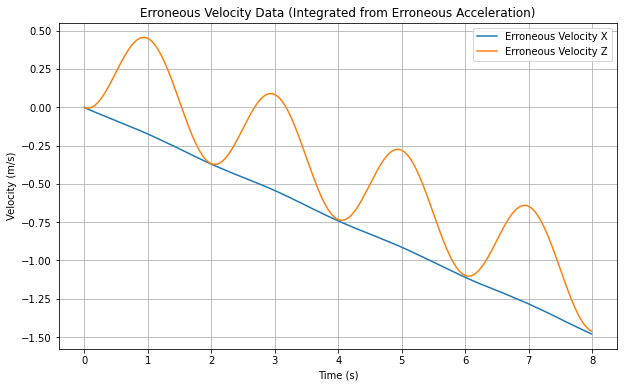

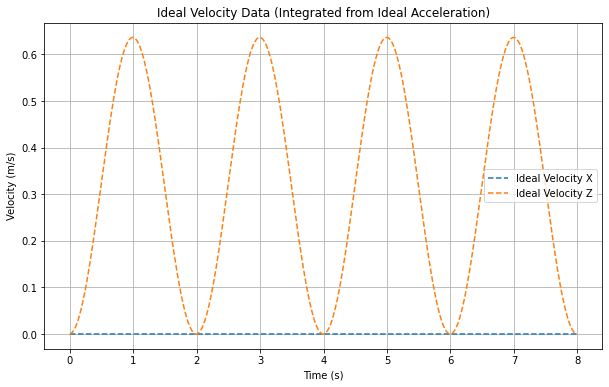

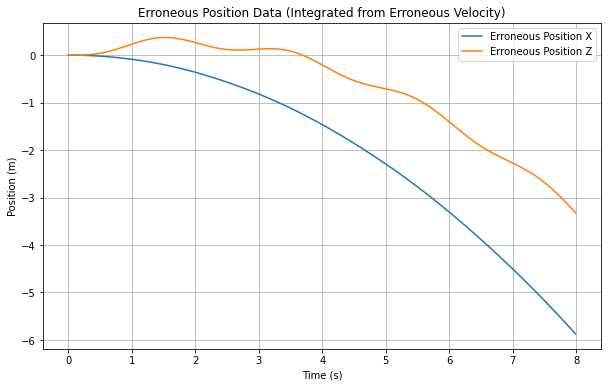

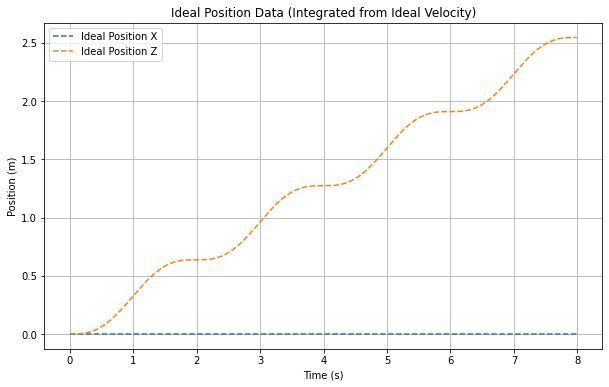

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def apply_imu_errors(acc_x, acc_y, acc_z, ssft, non_lin, nsd, cross_axis_sensitivity, noise_bandwidth):
    """
    Applies a set of error models to IMU acceleration signals.
    
    Parameters:
        acc_x (np.ndarray): Acceleration data for the x-axis.
        acc_y (np.ndarray): Acceleration data for the y-axis.
        acc_z (np.ndarray): Acceleration data for the z-axis.
        ssft (float): Scale factor sensitivity error (applied multiplicatively).
        non_lin (float): Non-linearity coefficient (applied as a quadratic term).
        nsd (float): Noise spectral density in mg/√Hz.
        cross_axis_sensitivity (float): Cross-axis sensitivity factor (fraction of other axes' error added).
        noise_bandwidth (float): Noise bandwidth in Hz (i.e., the effective bandwidth for the sensor noise).
    
    Returns:
        tuple: Corrected acceleration arrays for x, y, and z axes.
    """
    
    # Apply scale factor and non-linearity errors to each axis.
    error_x = acc_x * (1 + ssft) + non_lin * (acc_x ** 2)
    error_y = acc_y * (1 + ssft) + non_lin * (acc_y ** 2)
    error_z = acc_z * (1 + ssft) + non_lin * (acc_z ** 2)
    
    # Apply cross-axis sensitivity: each axis is contaminated by a fraction of the other axes' errors.
    corrected_x = error_x + cross_axis_sensitivity * (error_y + error_z)
    corrected_y = error_y + cross_axis_sensitivity * (error_x + error_z)
    corrected_z = error_z + cross_axis_sensitivity * (error_x + error_y)
    
    # Convert NSD from mg/√Hz to m/s²/√Hz (1 mg ≈ 0.0098 m/s²)
    nsd_mps2 = nsd * 0.0098
    
    # Compute per-sample noise standard deviation based on the noise bandwidth.
    noise_std = nsd_mps2 * np.sqrt(noise_bandwidth)
    
    # Add Gaussian noise to each axis based on the computed noise standard deviation.
    noise_x = np.random.normal(0, noise_std, size=acc_x.shape)
    noise_y = np.random.normal(0, noise_std, size=acc_y.shape)
    noise_z = np.random.normal(0, noise_std, size=acc_z.shape)
    
    corrected_x += noise_x
    corrected_y += noise_y
    corrected_z += noise_z
    
    return corrected_x, corrected_y, corrected_z

# Simulation parameters
duration = 8          # seconds
dt = 0.01              # sampling interval (seconds)
t = np.arange(0, duration, dt)

# Define example acceleration signals (ideal, non-error signals):
acc_x = np.zeros_like(t)                      # x-axis: no acceleration
acc_y = -9.8 * np.ones_like(t)                  # y-axis: constant gravity
acc_z = 1.0 * np.sin(2 * np.pi * 0.5 * t)        # z-axis: walking profile

# Error parameters (example values)
ssft = -0.005                    # scale factor error
non_lin = 0.005                  # small non-linearity coefficient
nsd = 0.23                       # NSD in mg/√Hz (e.g., 0.23 mg/√Hz)
cross_axis_sensitivity = 0.02    # cross-axis sensitivity
noise_bandwidth = 20             # effective noise bandwidth in Hz

# Apply errors to the acceleration signals
acc_x_err, acc_y_err, acc_z_err = apply_imu_errors(
    acc_x, acc_y, acc_z, ssft, non_lin, nsd, cross_axis_sensitivity, noise_bandwidth
)

# Integrate the erroneous acceleration to obtain velocity.
# Assume initial velocity is zero.
v_x = np.cumsum(acc_x_err) * dt
v_y = np.cumsum(acc_y_err) * dt
v_z = np.cumsum(acc_z_err) * dt

# Integrate velocity to obtain position.
# Assume initial position is zero.
p_x = np.cumsum(v_x) * dt
p_y = np.cumsum(v_y) * dt
p_z = np.cumsum(v_z) * dt

# --- Compute ideal (non-error) velocity and position ---

# Ideal velocity: integrate the ideal acceleration signals.
v_x_ideal = np.cumsum(acc_x) * dt
v_y_ideal = np.cumsum(acc_y) * dt
v_z_ideal = np.cumsum(acc_z) * dt

# Ideal position: integrate the ideal velocity.
p_x_ideal = np.cumsum(v_x_ideal) * dt
p_y_ideal = np.cumsum(v_y_ideal) * dt
p_z_ideal = np.cumsum(v_z_ideal) * dt

# --- Plotting ---

# Plot erroneous velocity data (for x and z axes)
plt.figure(figsize=(10, 6))
plt.plot(t, v_x, label='Erroneous Velocity X')
plt.plot(t, v_z, label='Erroneous Velocity Z')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Erroneous Velocity Data (Integrated from Erroneous Acceleration)')
plt.legend()
plt.grid(True)
plt.show()

# Plot ideal velocity data (for x and z axes)
plt.figure(figsize=(10, 6))
plt.plot(t, v_x_ideal, label='Ideal Velocity X', linestyle='--')
plt.plot(t, v_z_ideal, label='Ideal Velocity Z', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Ideal Velocity Data (Integrated from Ideal Acceleration)')
plt.legend()
plt.grid(True)
plt.show()

# Plot erroneous position data (for x and z axes)
plt.figure(figsize=(10, 6))
plt.plot(t, p_x, label='Erroneous Position X')
plt.plot(t, p_z, label='Erroneous Position Z')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Erroneous Position Data (Integrated from Erroneous Velocity)')
plt.legend()
plt.grid(True)
plt.show()

# Plot ideal position data (for x and z axes)
plt.figure(figsize=(10, 6))
plt.plot(t, p_x_ideal, label='Ideal Position X', linestyle='--')
plt.plot(t, p_z_ideal, label='Ideal Position Z', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Ideal Position Data (Integrated from Ideal Velocity)')
plt.legend()
plt.grid(True)
plt.show()


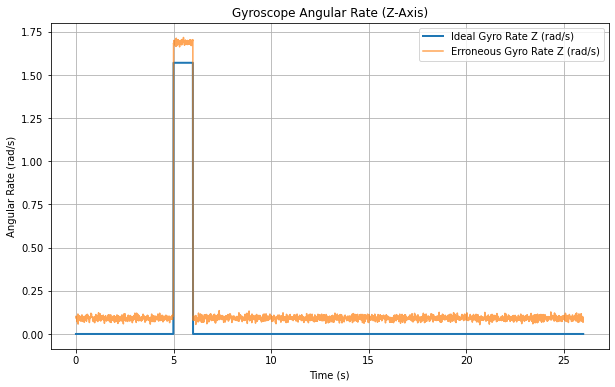

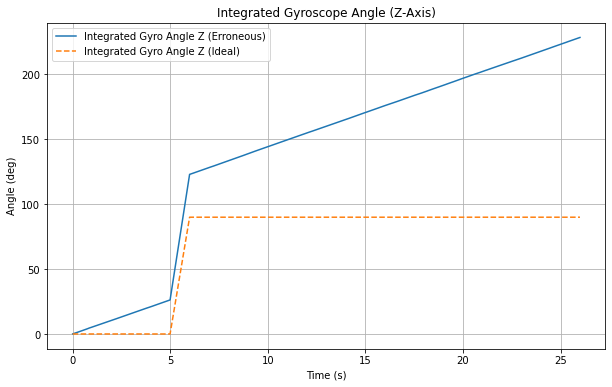

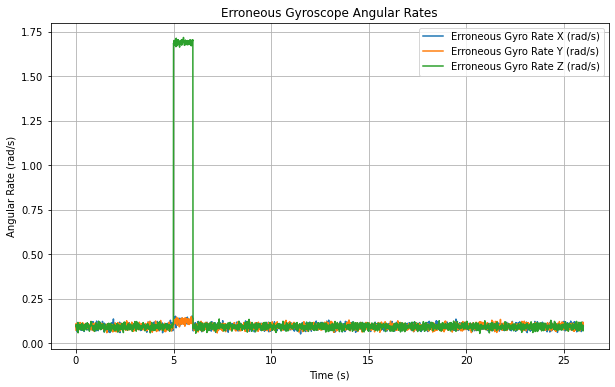

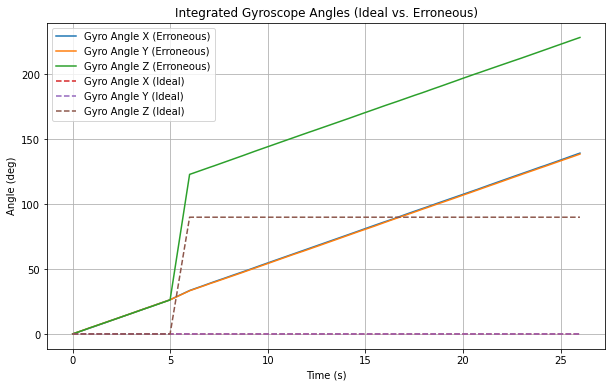

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def apply_gyro_errors(rate_x, rate_y, rate_z,
                      init_zro_x, init_zro_y, init_zro_z,
                      ssft, non_lin, nsd, cross_axis_sensitivity, noise_bandwidth):
    """
    Applies a set of error models to gyroscope angular rate signals.
    
    Parameters:
        rate_x, rate_y, rate_z (np.ndarray): Ideal angular rate data (in rad/s) for the x, y, and z axes.
        init_zro_x, init_zro_y, init_zro_z (float): Initial zero offset errors (bias) for each axis (in rad/s).
        ssft (float): Scale factor sensitivity error (multiplicative error).
        non_lin (float): Non-linearity coefficient (quadratic term applied to the rate).
        nsd (float): Noise spectral density in rad/s/√Hz.
        cross_axis_sensitivity (float): Fraction of the errors from the other axes that contaminates each axis.
        noise_bandwidth (float): Effective noise bandwidth in Hz.
    
    Returns:
        tuple: Corrected angular rate arrays for the x, y, and z axes.
    """
    # Add initial zero offset error (bias)
    err_x = rate_x + init_zro_x
    err_y = rate_y + init_zro_y
    err_z = rate_z + init_zro_z
    
    # Apply scale factor error and non-linearity.
    err_x = err_x * (1 + ssft) + non_lin * (err_x ** 2)
    err_y = err_y * (1 + ssft) + non_lin * (err_y ** 2)
    err_z = err_z * (1 + ssft) + non_lin * (err_z ** 2)
    
    # Apply cross-axis sensitivity: each axis is contaminated by a fraction of the other axes' errors.
    corrected_x = err_x + cross_axis_sensitivity * (err_y + err_z)
    corrected_y = err_y + cross_axis_sensitivity * (err_x + err_z)
    corrected_z = err_z + cross_axis_sensitivity * (err_x + err_y)
    
    # Compute per-sample noise standard deviation:
    # Assuming white noise, per-sample std = nsd * sqrt(noise_bandwidth)
    noise_std = nsd * np.sqrt(noise_bandwidth)
    
    # Add Gaussian noise to each axis.
    noise_x = np.random.normal(0, noise_std, size=rate_x.shape)
    noise_y = np.random.normal(0, noise_std, size=rate_y.shape)
    noise_z = np.random.normal(0, noise_std, size=rate_z.shape)
    
    corrected_x += noise_x
    corrected_y += noise_y
    corrected_z += noise_z
    
    return corrected_x, corrected_y, corrected_z

# --------------------------------------------------
# Simulation parameters
dt = 0.01               # Sampling interval in seconds.
t_total = 26             # Total simulation time: 5 sec still + 1 sec rotation + 20 sec still = 26 seconds.
t = np.arange(0, t_total, dt)

# --------------------------------------------------
# Generate ideal gyroscope angular rate signals (in rad/s).
# Create arrays for x, y, z axes.
rate_x = np.zeros_like(t)
rate_y = np.zeros_like(t)
rate_z = np.zeros_like(t)

# Define the test profile:
# - t=0 to 5 s: Stationary (0 rad/s)
# - t=5 to 6 s: Rotate 90° over 1 second around the z-axis (angular rate = pi/2 rad/s)
# - t=6 to 26 s: Stationary (0 rad/s)
idx_rotation = np.logical_and(t >= 5, t < 6)
rate_z[idx_rotation] = np.pi/2  # Constant rate for 90° rotation (rad/s)

# --------------------------------------------------
# Define gyroscope error parameters (example values):
init_zro_x = 0.0873   # Initial zero offset error for x-axis (rad/s)
init_zro_y = 0.0873   # For y-axis (rad/s)
init_zro_z = 0.0873   # For z-axis (rad/s)
ssft = 0.015           # Scale factor sensitivity error (1% error)
non_lin = 0.001       # Non-linearity coefficient
nsd = 0.015 * 0.1745           # Noise spectral density in rad/s/√Hz
cross_axis_sensitivity = 0.02  # 2% cross-axis sensitivity
noise_bandwidth = 20  # Effective noise bandwidth in Hz

# --------------------------------------------------
# Apply the error model to the ideal gyroscope signals.
rate_x_err, rate_y_err, rate_z_err = apply_gyro_errors(
    rate_x, rate_y, rate_z,
    init_zro_x, init_zro_y, init_zro_z,
    ssft, non_lin, nsd, cross_axis_sensitivity, noise_bandwidth
)

# --------------------------------------------------
# Integrate the (erroneous) angular rates to obtain angular displacement (angle in radians).
angle_x = np.cumsum(rate_x_err) * dt
angle_y = np.cumsum(rate_y_err) * dt
angle_z = np.cumsum(rate_z_err) * dt

# Also compute the ideal integrated angles for comparison.
angle_x_ideal = np.cumsum(rate_x) * dt
angle_y_ideal = np.cumsum(rate_y) * dt
angle_z_ideal = np.cumsum(rate_z) * dt

# --------------------------------------------------
# Plotting

# 1. Plot the ideal vs. erroneous gyroscope rate for the z-axis.
plt.figure(figsize=(10, 6))
plt.plot(t, rate_z, label='Ideal Gyro Rate Z (rad/s)', linewidth=2)
plt.plot(t, rate_z_err, label='Erroneous Gyro Rate Z (rad/s)', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Angular Rate (rad/s)')
plt.title('Gyroscope Angular Rate (Z-Axis)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Plot the integrated angle (z-axis) in degrees:
plt.figure(figsize=(10, 6))
plt.plot(t, angle_z * (180/np.pi), label='Integrated Gyro Angle Z (Erroneous)')
plt.plot(t, angle_z_ideal * (180/np.pi), label='Integrated Gyro Angle Z (Ideal)', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.title('Integrated Gyroscope Angle (Z-Axis)')
plt.legend()
plt.grid(True)
plt.show()

# 3. (Optional) Plot the erroneous angular rates for all three axes.
plt.figure(figsize=(10, 6))
plt.plot(t, rate_x_err, label='Erroneous Gyro Rate X (rad/s)')
plt.plot(t, rate_y_err, label='Erroneous Gyro Rate Y (rad/s)')
plt.plot(t, rate_z_err, label='Erroneous Gyro Rate Z (rad/s)')
plt.xlabel('Time (s)')
plt.ylabel('Angular Rate (rad/s)')
plt.title('Erroneous Gyroscope Angular Rates')
plt.legend()
plt.grid(True)
plt.show()

# 4. (Optional) Plot the integrated angles (all axes) in degrees.
plt.figure(figsize=(10, 6))
plt.plot(t, angle_x * (180/np.pi), label='Gyro Angle X (Erroneous)')
plt.plot(t, angle_y * (180/np.pi), label='Gyro Angle Y (Erroneous)')
plt.plot(t, angle_z * (180/np.pi), label='Gyro Angle Z (Erroneous)')
plt.plot(t, angle_x_ideal * (180/np.pi), label='Gyro Angle X (Ideal)', linestyle='--')
plt.plot(t, angle_y_ideal * (180/np.pi), label='Gyro Angle Y (Ideal)', linestyle='--')
plt.plot(t, angle_z_ideal * (180/np.pi), label='Gyro Angle Z (Ideal)', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.title('Integrated Gyroscope Angles (Ideal vs. Erroneous)')
plt.legend()
plt.grid(True)
plt.show()


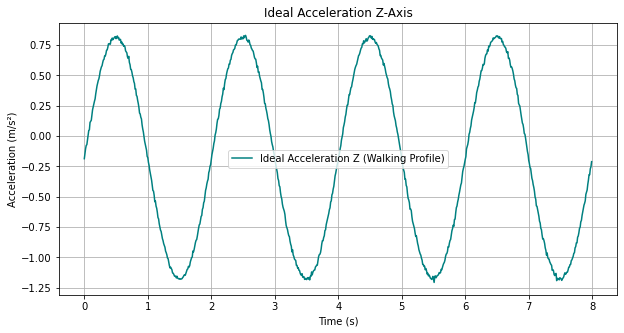

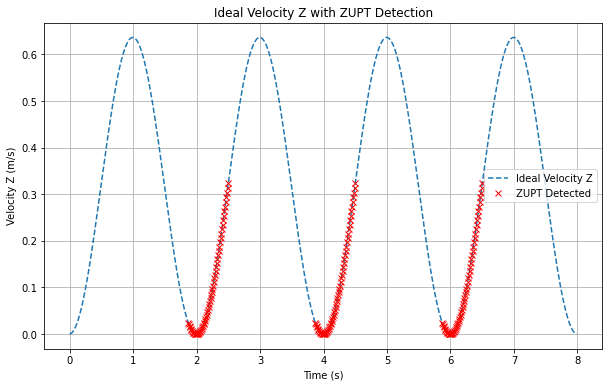

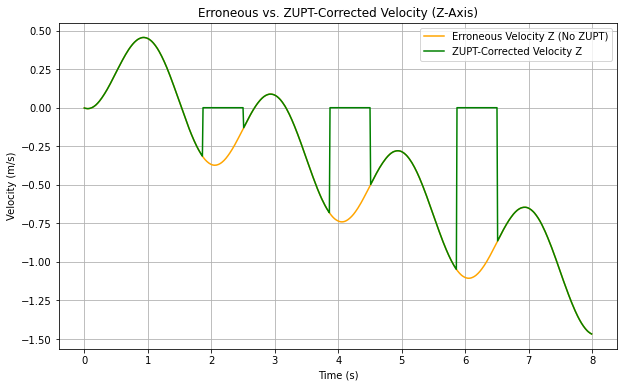

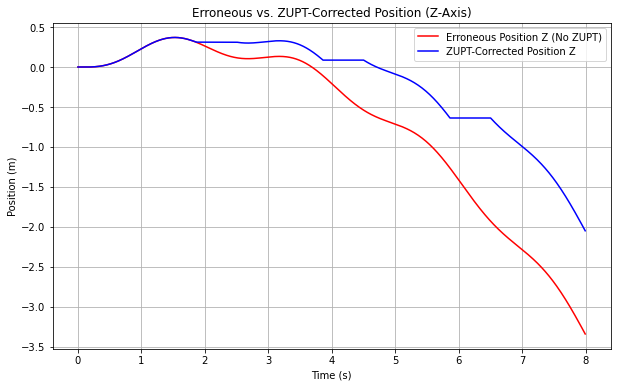

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def apply_imu_errors(acc_x, acc_y, acc_z, ssft, non_lin, nsd, cross_axis_sensitivity, noise_bandwidth):
    nsd_mps2 = nsd * 0.0098
    noise_std = nsd_mps2 * np.sqrt(noise_bandwidth)
    
    error_x = acc_x * (1 + ssft) + non_lin * (acc_x ** 2)
    error_y = acc_y * (1 + ssft) + non_lin * (acc_y ** 2)
    error_z = acc_z * (1 + ssft) + non_lin * (acc_z ** 2)

    corrected_x = error_x + cross_axis_sensitivity * (error_y + error_z)
    corrected_y = error_y + cross_axis_sensitivity * (error_x + error_z)
    corrected_z = error_z + cross_axis_sensitivity * (error_x + error_y)

    corrected_x += np.random.normal(0, noise_std, size=acc_x.shape)
    corrected_y += np.random.normal(0, noise_std, size=acc_y.shape)
    corrected_z += np.random.normal(0, noise_std, size=acc_z.shape)

    return corrected_x, corrected_y, corrected_z

# --- Simulation Parameters ---
duration = 8
dt = 0.01
t = np.arange(0, duration, dt)

# --- Ideal Acceleration Signals ---
acc_x = np.zeros_like(t)
acc_y = -9.8 * np.ones_like(t)
acc_z = 1.0 * np.sin(2 * np.pi * 0.5 * t)

# --- Error Parameters ---
ssft = -0.005
non_lin = 0.005
nsd = 0.23  # mg/√Hz
cross_axis_sensitivity = 0.02
noise_bandwidth = 20

# --- Apply IMU Errors ---
acc_x_err, acc_y_err, acc_z_err = apply_imu_errors(
    acc_x, acc_y, acc_z, ssft, non_lin, nsd, cross_axis_sensitivity, noise_bandwidth
)

# --- Velocity Integration ---
v_x = np.cumsum(acc_x_err) * dt
v_y = np.cumsum(acc_y_err) * dt
v_z = np.cumsum(acc_z_err) * dt

"""
# --- ZUPT Detection using STD over a window ---
window_size = 100  # ~0.5s if dt = 0.01
acc_mag = np.sqrt(acc_z_err**2)
std_acc = np.array([
    np.std(acc_mag[max(0, i - window_size):min(len(acc_mag), i + window_size)])
    for i in range(len(acc_mag))
])
zupt_threshold = 0.35  # m/s²
zupt_mask = std_acc < zupt_threshold

window_size = 100
"""
# --- ZUPT Detection: Mean Amplitude + Direction Check (Z-axis only) ---
window_size = 60
mean_amp_z = np.zeros_like(acc_z_err)
zupt_mask = np.zeros_like(acc_z_err, dtype=bool)

for i in range(len(acc_z_err)):
    start = max(0, i - window_size)
    end = min(len(acc_z_err), i + window_size)
    window = acc_z_err[start:end]
    
    if len(window) < 2:
        continue

    mean_amp = np.mean(window)
    first_val = window[0]
    last_val = window[-1]

    # Trigger ZUPT if mean near zero and acceleration is returning to rest
    if abs(mean_amp) < 0.4 and abs(last_val) < abs(first_val):
        zupt_mask[i] = True




# --- ZUPT-Corrected Velocity ---
v_x_zupt = v_x.copy()
v_y_zupt = v_y.copy()
v_z_zupt = v_z.copy()
v_x_zupt[zupt_mask] = 0
v_y_zupt[zupt_mask] = 0
v_z_zupt[zupt_mask] = 0

# --- Position Integration ---
p_x = np.cumsum(v_x) * dt
p_y = np.cumsum(v_y) * dt
p_z = np.cumsum(v_z) * dt
p_x_zupt = np.cumsum(v_x_zupt) * dt
p_y_zupt = np.cumsum(v_y_zupt) * dt
p_z_zupt = np.cumsum(v_z_zupt) * dt

# --- Ideal Integration ---
v_x_ideal = np.cumsum(acc_x) * dt
v_y_ideal = np.cumsum(acc_y) * dt
v_z_ideal = np.cumsum(acc_z) * dt
p_x_ideal = np.cumsum(v_x_ideal) * dt
p_y_ideal = np.cumsum(v_y_ideal) * dt
p_z_ideal = np.cumsum(v_z_ideal) * dt

# --- Plot Ideal Acceleration (Z-axis) ---
plt.figure(figsize=(10, 5))
plt.plot(t, acc_z_err, label='Ideal Acceleration Z (Walking Profile)', color='teal')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Ideal Acceleration Z-Axis')
plt.grid(True)
plt.legend()
plt.show()

# --- Plot Ideal Velocity Z + ZUPT Markers ---
plt.figure(figsize=(10, 6))
plt.plot(t, v_z_ideal, label='Ideal Velocity Z', linestyle='--')
plt.plot(t[zupt_mask], v_z_ideal[zupt_mask], 'rx', label='ZUPT Detected')
plt.xlabel('Time (s)')
plt.ylabel('Velocity Z (m/s)')
plt.title('Ideal Velocity Z with ZUPT Detection')
plt.legend()
plt.grid(True)
plt.show()

# --- Comparison Plot: Velocity with vs without ZUPT ---
plt.figure(figsize=(10, 6))
plt.plot(t, v_z, label='Erroneous Velocity Z (No ZUPT)', color='orange')
plt.plot(t, v_z_zupt, label='ZUPT-Corrected Velocity Z', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Erroneous vs. ZUPT-Corrected Velocity (Z-Axis)')
plt.legend()
plt.grid(True)
plt.show()

# --- Comparison Plot: Position with vs without ZUPT ---
plt.figure(figsize=(10, 6))
plt.plot(t, p_z, label='Erroneous Position Z (No ZUPT)', color='red')
plt.plot(t, p_z_zupt, label='ZUPT-Corrected Position Z', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Erroneous vs. ZUPT-Corrected Position (Z-Axis)')
plt.legend()
plt.grid(True)
plt.show()
